In [3]:
# %load gen_response_data.py
#!/usr/bin/env python
# ==================================
# File Name: gen_response_data.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-08-31 09:40:34
# ==================================

import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, get_XYZ_fd, get_AET_fd, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.Constants import DAY, YRSID_SI

In [1]:



def generate_td_data(pars, s_type='gcb', det='TQ', Tobs=YRSID_SI, dt=1, show_y_slr=False):
    print("This is TD response generation code")

    # tf = np.arange(0,Tobs, delta_T)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/dt))

    print(f"Testing of {s_type} waveform")
    wf = waveforms[s_type](**pars)
    st = time.time()
    y_slr = get_y_slr_td(wf, tf, det)
    ed = time.time()
    print(f"Time cost is {ed-st} s for {tf.shape[0]} points")

    if show_y_slr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][f"{j}L"])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(y_slr)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    ed = time.time()
    print("Time cost for cal XYZ and AET with y_slr is ", ed-st)
    # np.save(det+s_type+"_X_td.npy", np.array([tf, X]))
    return (tf,X,Y,Z,A,E,T)

In [13]:
f0 = [0.00622028]
fd = [7.48528554e-16]
beta = [-0.082205]  # ecliptic latitude [rad]
Lambda = [2.10225]  # ecliptic longitude [rad]

Amp = [6.37823e-23]
iota = [0.645772]
psi = [2.91617795]
phi0 = [3.1716561]
Tobs = 62914560.0
Cadence = 15.0

In [37]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": 2.10225,
    "Beta": -0.082205,
    "T_obs": YRSID_SI,
}

In [38]:
gcbwf = waveforms["gcb"](**GCBpars, dt=15)

In [39]:
gcbwf.amp/Amp[0]

1.0000000000000002

In [40]:
tf,X,Y,Z,A,E,T = generate_td_data(GCBpars, dt=15)

This is TD response generation code
Testing of gcb waveform
Time cost is 2.640327215194702 s for 2103876 points
Time cost for cal XYZ and AET with y_slr is  0.05746054649353027


In [49]:
dt = 15
fs = 1/dt

X_fd = np.fft.rfft(X)/len(X)*2

xf = np.linspace(0,fs/2,len(X_fd))

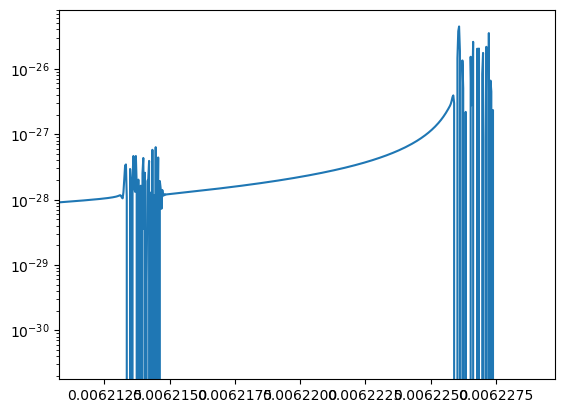

In [50]:
#plt.plot(tf,X)
plt.plot(xf, X_fd)

f0 = GCBpars["f0"]

#plt.axvline(f0, color="red", ls="--")

df = xf[1]-xf[0]
plt.xlim(f0-300*df, f0+300*df)
#plt.xlim(0.025,0.030)
#plt.xscale("log")
plt.yscale("log")

In [18]:
from gwspace.Orbit import TianQinOrbit
from gwspace.Orbit import get_pos

In [20]:
st = time.time()
Tobs = YRSID_SI
delta_T = 10
tf = np.arange(0, Tobs, delta_T)

TQOrbit = TianQinOrbit(tf)
ed = time.time()
print(f"Time cost for initial position: {ed-st} s")

p1, p2, p3 = TQOrbit.orbits

Time cost for initial position: 0.6421749591827393 s


In [21]:
p1

array([[-1.27729940e+02, -1.27728976e+02, -1.27728013e+02, ...,
        -1.28031897e+02, -1.28030994e+02, -1.28030091e+02],
       [-4.84202950e+02, -4.84203192e+02, -4.84203434e+02, ...,
        -4.84410022e+02, -4.84410292e+02, -4.84410563e+02],
       [ 0.00000000e+00, -6.63637412e-05, -1.32727480e-04, ...,
        -3.31130698e-01, -3.31124802e-01, -3.31118892e-01]])

In [22]:
x,y,z,l = get_pos(tf)

In [23]:
x

array([[-127.72993986, -127.72897644, -127.72801304, ..., -127.7543444 ,
        -127.75340567, -127.75246696],
       [-128.14903926, -128.14812957, -128.14721988, ..., -128.24845257,
        -128.24752682, -128.24660106],
       [-128.17306611, -128.17205724, -128.17104836, ..., -128.05782604,
        -128.05680854, -128.05579105]])

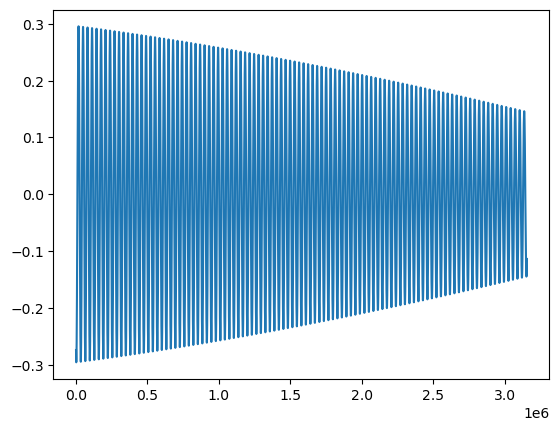

In [27]:
plt.plot(y[1] - p1[1])

In [57]:
from gwspace.Waveform import GCBWaveform as gcb
from gwspace.response import trans_y_slr_fd as trans
from gwspace.Orbit import get_pos

In [61]:
def transfer_slr(freq, LT, knl, krr, krs):
    return 0.5 * np.sinc(freq*LT * (1-knl)) * np.exp(-1j*freq*(LT+krr+krs))

def _dot_arr(a,b):
    return a[0]*b[0]+a[1]*b[1]+a[2]*b[2]

def _cal_zeta(u,v,n):
    nu = _dot_arr(n,u)
    nv = _dot_arr(n,v)
    zp = nu**2 - nv**2
    zc = 2*nu*nv
    return zp, zc

def _cal_xi(tf,k,r):
    return tf - _dot_arr(k,r)

def get_yslr(tf, freq, u,v,k, wf, detector="TianQin"):
    xt,yt,zt,LT = get_pos(tf, detector)
    ni = lambda i,j: np.array([xt[j]-xt[i], yt[j]-yt[i], zt[j]-zt[i]])/LT    
    n1 = ni(2,1); n2 = ni(0,2); n3 = ni(1,0)
    kn1 = _dot_arr(k,n1)
    kn2 = _dot_arr(k,n2)
    kn3 = _dot_arr(k,n3)

    kr1 = _dot_arr(k, np.array([xt[0],yt[0],zt[0]]))
    kr2 = _dot_arr(k, np.array([xt[1],yt[1],zt[1]]))
    kr3 = _dot_arr(k, np.array([xt[2],yt[2],zt[2]]))

    zp1,zc1 = _cal_zeta(u,v,n1)
    zp2,zc2 = _cal_zeta(u,v,n2)
    zp3,zc3 = _cal_zeta(u,v,n3)

    sinc12 = np.sinc(freq*LT*(1+kn3))
    sinc23 = np.sinc(freq*LT*(1+kn1))
    sinc31 = np.sinc(freq*LT*(1+kn2))

    sinc21 = np.sinc(freq*LT*(1-kn3))
    sinc32 = np.sinc(freq*LT*(1-kn1))
    sinc13 = np.sinc(freq*LT*(1-kn2))

    exp12 = np.exp(-1j*np.pi*freq*(LT+kr1+kr2))
    exp23 = np.exp(-1j*np.pi*freq*(LT+kr2+kr3))
    exp31 = np.exp(-1j*np.pi*freq*(LT+kr3+kr1))

    fact = -1j*np.pi*freq*LT

    yslr = {}
    for i in range(4):
        ts = tf - i*LT
        hp, hc = wf.get_hphc(ts)
        yslr["%sL"%i] = {
            (1,2): fact*sinc12*exp12*(zp3*hp + zc3*hc),
            (2,1): fact*sinc21*exp12*(zp3*hp + zc3*hc),
            (2,3): fact*sinc23*exp23*(zp1*hp + zc1*hc),
            (3,2): fact*sinc32*exp23*(zp1*hp + zc1*hc),
            (3,1): fact*sinc31*exp31*(zp2*hp + zc2*hc),
            (1,3): fact*sinc13*exp31*(zp2*hp + zc2*hc),
        }
    return yslr

In [62]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": 2.10225,
    "Beta": -0.082205,
    "T_obs": YRSID_SI,
}

gcbwf = gcb(**GCBpars)

dt = 15
tf = np.arange(0,YRSID_SI, dt)
det = detectors["TQ"](tf)


In [63]:
u,v,k = gcbwf.vec_u, gcbwf.vec_v, gcbwf.vec_k
hp, hc = gcbwf.get_hphc(tf)
freq = GCBpars["f0"]

yslr = get_yslr(tf, freq, u,v,k, gcbwf, detector="TianQin")

In [65]:
X_td = yslr["0L"][(3,1)]

In [72]:
X_fd = np.fft.rfft(X_td)/X

(array([0.86207128, 0.50678705, 0.        ]),
 array([-0.04161352,  0.07078678,  0.99662307]),
 array([ 0.50507566, -0.85916013,  0.08211245]))

In [88]:
xt,yt,zt,LT = get_pos(tf, "TianQin")

ni = lambda i,j: np.array([xt[j]-xt[i], yt[j]-yt[i], zt[j]-zt[i]])/LT    
n1 = ni(2,1); n2 = ni(0,2); n3 = ni(1,0)
kn1 = _dot_arr(k,n1)
kn2 = _dot_arr(k,n2)
kn3 = _dot_arr(k,n3)

kn1.shape

(2103877,)

In [89]:
xt.shape, n1.shape

((3, 2103877), (3, 2103877))

In [91]:
kr1 = _dot_arr(k, np.array([xt[0],yt[0],zt[0]]))
kr2 = _dot_arr(k, np.array([xt[1],yt[1],zt[1]]))
kr3 = _dot_arr(k, np.array([xt[2],yt[2],zt[2]]))

kr1

array([351.49458332, 351.49561692, 351.49665053, ..., 351.49184611,
       351.49287976, 351.49391341])

In [92]:
zp1,zc1 = _cal_zeta(u,v,n1)
zp2,zc2 = _cal_zeta(u,v,n2)
zp3,zc3 = _cal_zeta(u,v,n3)

zp1

array([-0.99999996, -0.99999987, -0.99999942, ..., -0.63646533,
       -0.6360042 , -0.63554283])

In [93]:
sinc12 = np.sinc(freq*LT*(1+kn3))
sinc23 = np.sinc(freq*LT*(1+kn1))
sinc31 = np.sinc(freq*LT*(1+kn2))
sinc21 = np.sinc(freq*LT*(1-kn3))
sinc32 = np.sinc(freq*LT*(1-kn1))
sinc13 = np.sinc(freq*LT*(1-kn2))

sinc12

array([0.99997878, 0.99997878, 0.99997878, ..., 0.99997879, 0.99997879,
       0.99997879])

In [94]:
exp12 = np.exp(-1j*np.pi*freq*(LT+kr1+kr2))
exp23 = np.exp(-1j*np.pi*freq*(LT+kr2+kr3))
exp31 = np.exp(-1j*np.pi*freq*(LT+kr3+kr1))
fact = -1j*np.pi*freq*LT

exp12

array([0.37865815-0.9255366j , 0.37862076-0.9255519j ,
       0.37858337-0.9255672j , ..., 0.37875522-0.92549689j,
       0.37871783-0.92551219j, 0.37868044-0.92552749j])

In [95]:
fact*sinc12*exp12*zp3*hp

array([-5.45400715e-25-2.23135882e-25j, -4.45725496e-25-1.82335454e-25j,
       -1.96830853e-25-8.05094301e-26j, ...,
        5.88223542e-25+2.40727697e-25j, -8.76145220e-27-3.58516957e-27j,
       -6.02959259e-25-2.46701344e-25j])

In [96]:
yslr = {
    (1,2): fact*sinc12*exp12*(zp3*hp + zc3*hc),
    (2,1): fact*sinc21*exp12*(zp3*hp + zc3*hc),
    (2,3): fact*sinc23*exp23*(zp1*hp + zc1*hc),
    (3,2): fact*sinc32*exp23*(zp1*hp + zc1*hc),
    (3,1): fact*sinc31*exp31*(zp2*hp + zc2*hc),
    (1,3): fact*sinc13*exp31*(zp2*hp + zc2*hc),
}

/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


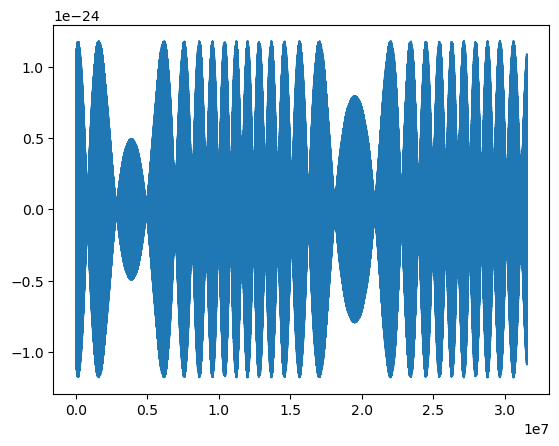

In [97]:
plt.plot(tf, yslr[(1,2)])

In [71]:
# %load gen_response_data.py
#!/usr/bin/env python
# ==================================
# File Name: gen_response_data.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-08-31 09:40:34
# ==================================

import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, get_XYZ_fd, get_AET_fd, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.Constants import DAY, YRSID_SI, MONTH


def generate_td_data(pars, s_type='gcb', det='TQ', show_y_slr=False):
    print("This is TD response generation code")
    Tobs = 10*DAY  # YRSID_SI / 4
    delta_T = 1

    # tf = np.arange(0,Tobs, delta_T)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/delta_T))

    print(f"Testing of {s_type} waveform")
    wf = waveforms[s_type](**pars)
    st = time.time()
    y_slr = get_y_slr_td(wf, tf, det)
    ed = time.time()
    print(f"Time cost is {ed-st} s for {tf.shape[0]} points")

    if show_y_slr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][f"{j}L"])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(y_slr)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    ed = time.time()
    print("Time cost for cal XYZ and AET with y_slr is ", ed-st)
    # np.save(det+s_type+"_X_td.npy", np.array([tf, X]))

    plt.subplots(2, 3, sharex='all', sharey='all', figsize=(12, 8))
    for i, dd in enumerate(["X", "Y", "Z", "A", "E", "T"]):
        dat = eval(dd)
        plt.subplot(2, 3, i+1)
        plt.plot(tf[:-5], dat[:-5])
        plt.xlabel("Time")
        plt.ylabel("h")
        plt.title(dd)
    plt.tight_layout()


def generate_fd_data(pars, s_type='bhb_PhenomD', det='TQ', show_y_slr=False):
    print("This is a test for frequency domain response")

    NF = 10240
    freq = 10**np.linspace(-4, 0, NF)

    print(f"Testing of {s_type} waveform")
    BHBwf = waveforms[s_type](**pars)
    amp, phase, tf = BHBwf.get_amp_phase(freq)
    amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]

    det = detectors[det](tf)
    h22 = amp * np.exp(1j*phase) * np.exp(2j*np.pi*freq*BHBwf.tc)

    st = time.time()
    y_slr = trans_y_slr_fd(BHBwf.vec_k, BHBwf.p22, det, freq)[0]
    y_slr = {k: v*h22 for k, v in y_slr.items()}
    ed = time.time()
    print(f"time cost for the fd response is {ed-st} s")

    if show_y_slr:
        ln = [(1, 2), (2, 3), (3, 1), (1, 3), (3, 2), (2, 1)]
        plt.figure()
        plt.xscale('log')
        for ll in ln:
            plt.plot(freq, np.abs(y_slr[ll]), label=ll)
        plt.legend()
        plt.tight_layout()

    X, Y, Z = get_XYZ_fd(y_slr, freq, det.L_T)
    A, E, T = get_AET_fd(y_slr, freq, det.L_T)

    plt.figure()
    plt.loglog(freq, np.abs(X), '-', label='X')
    plt.loglog(freq, np.abs(Y), '-', label='Y')
    plt.loglog(freq, np.abs(Z), '-', label='Z')
    plt.loglog(freq, np.abs(A), '--', label='A')
    plt.loglog(freq, np.abs(E), '--', label='E')
    plt.loglog(freq, np.abs(T), '--', label='T')
    plt.xlabel('f')
    plt.ylabel('h')
    plt.legend()
    plt.tight_layout()


if __name__ == "__main__":
    GCBpars = {"mass1": 0.5,
               "mass2": 0.5,
               "DL": 0.3,
               "phi0": 0.0,
               "f0": 0.001,
               "psi": 0.2,
               "iota": 0.3,
               "Lambda": 0.4,
               "Beta": 1.2,
               "T_obs": YRSID_SI,
               }
    EMRIpars = {'M': 1e6,
                'a': 0.1,
                'mu': 1e1,
                'p0': 12.0,
                'e0': 0.2,
                'x0': 1.0,
                'qK': 0.2,
                'phiK': 0.2,
                'qS': 0.3,
                'phiS': 0.3,
                'dist': 1.0,
                'Phi_phi0': 1.0,
                'Phi_theta0': 2.0,
                'Phi_r0': 3.0,
                'psi': 0.4,
                'iota': 0.2,
                'T_obs': YRSID_SI,
                }
    BHBpars = {"mass1": 3.5e6,
               "mass2": 2.1e5,
               'T_obs': MONTH*3,
               "chi1": 0.2,
               "chi2": 0.1,
               "DL": 1e3,
               "psi": 0.2,
               "iota": 0.3,
               "Lambda": 0.4,
               "Beta": 1.2,
               "tc": 0,
               }
    ecc_par = {'DL': 100,  # Luminosity distance (Mpc)
               'mass1': 35.6,  # Primary mass (solar mass)
               'mass2': 30.6,  # Secondary mass(solar mass)
               'Lambda': 4.7,  # Longitude
               'Beta': -1.5,  # Latitude
               'phi_c': 0,  # Coalescence phase
               'T_obs': MONTH*3,  # Observation time (s)
               'tc': 0,  # Coalescence time (s)
               'iota': 0.3,  # Inclination angle
               'var_phi': 0,  # Observer phase
               'psi': 0.2,  # Polarization angle
               }  # masses of GW150914
    # generate_td_data(GCBpars)
    # generate_td_data(EMRIpars, s_type='emri')
    # generate_fd_data(BHBpars, show_y_slr=True)

    from gwspace.Noise import TianQinNoise, LISANoise, TaijiNoise

    tq_noise = TianQinNoise()
    lisa_noise = LISANoise()
    taiji_noise = TaijiNoise()
    freq_ = np.logspace(-5, 0, 10000)

    TQ_A, _ = tq_noise.noise_AET(freq_)
    LISA_A, _ = lisa_noise.noise_AET(freq_, wd_foreground=90/365.25)
    Taiji_A, _ = lisa_noise.noise_AET(freq_, wd_foreground=90/365.25)

    BHBwf = waveforms['bhb_PhenomD'](**BHBpars)
    delta_f = 1e-6  # 1/BHBwf.T_obs
    freq = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)
    amp, phase, tf = BHBwf.get_amp_phase(freq)
    amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]
    h22 = amp*np.exp(1j*phase)*np.exp(2j*np.pi*freq*BHBwf.tc)

    SMBBH_A = {}
    for d in ['TQ', 'LISA', 'Taiji']:
        det = detectors[d](tf)
        y_slr = trans_y_slr_fd(BHBwf.vec_k, BHBwf.p22, det, freq)[0]
        y_slr = {k: v*h22 for k, v in y_slr.items()}
        SMBBH_A[d], _, _ = get_AET_fd(y_slr, freq, det.L_T)

    plt.figure(figsize=(12, 8))
    plt.loglog(freq_, np.sqrt(TQ_A), 'm-', label='TQ_A')
    plt.loglog(freq_, np.sqrt(LISA_A), 'y-', label='LISA_A')
    plt.loglog(freq_, np.sqrt(Taiji_A), 'g-', label='Taiji_A')
    plt.loglog(freq, np.abs(SMBBH_A['TQ'])*np.sqrt(freq), 'r-', label='TQ')
    plt.loglog(freq, np.abs(SMBBH_A['LISA'])*np.sqrt(freq), 'b-', label='LISA')
    plt.loglog(freq, np.abs(SMBBH_A['Taiji'])*np.sqrt(freq), 'c-', label='Taiji')
    plt.xlabel('f(Hz)', fontsize=24)
    plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0.9*BHBwf.f_min, 1.1)
    plt.ylim(1e-23, 1e-16)
    plt.legend(fontsize=16)
    plt.tight_layout()

    BHBwf = waveforms['bhb_PhenomD'](**ecc_par)
    delta_f = 1e-5  # 1/BHBwf.T_obs
    freq_e0 = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)
    amp, phase, tf = BHBwf.get_amp_phase(freq_e0)
    amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]
    h22 = amp*np.exp(1j*phase)*np.exp(2j*np.pi*freq_e0*BHBwf.tc)

    ecc_wf = waveforms['bhb_EccFD'](**ecc_par, eccentricity=0.1)

    smBBH_A_e0, smBBH_A_e1 = {}, {}
    for d in ['TQ', 'LISA', 'Taiji']:
        det = detectors[d](tf)
        y_slr = trans_y_slr_fd(BHBwf.vec_k, BHBwf.p22, det, freq_e0)[0]
        y_slr = {k: v*h22 for k, v in y_slr.items()}
        smBBH_A_e0[d], _, _ = get_AET_fd(y_slr, freq_e0, det.L_T)

        smBBH_A_e1[d], freq_e1 = ecc_wf.fd_tdi_response(det=d, delta_f=delta_f)

    plt.figure(figsize=(12, 8))
    plt.loglog(freq_, np.sqrt(TQ_A), 'm--', label='TQ_A')
    plt.loglog(freq_, np.sqrt(LISA_A), 'y--', label='LISA_A')
    plt.loglog(freq_, np.sqrt(Taiji_A), 'g--', label='Taiji_A')
    plt.loglog(freq_e1, np.abs(smBBH_A_e1['TQ'])*np.sqrt(freq_e1), 'r-', label='TQ: e=0.1')
    plt.loglog(freq_e1, np.abs(smBBH_A_e1['LISA'])*np.sqrt(freq_e1), 'b-', label='LISA: e=0.1')
    plt.loglog(freq_e1, np.abs(smBBH_A_e1['Taiji'])*np.sqrt(freq_e1), 'c-', label='Taiji: e=0.1')
    plt.loglog(freq_e0, np.abs(smBBH_A_e0['TQ'])*np.sqrt(freq_e0), 'm-', label='TQ: e=0')
    plt.loglog(freq_e0, np.abs(smBBH_A_e0['LISA'])*np.sqrt(freq_e0), 'y-', label='LISA: e=0')
    plt.loglog(freq_e0, np.abs(smBBH_A_e0['Taiji'])*np.sqrt(freq_e0), 'g-', label='Taiji: e=0')
    plt.xlabel('f(Hz)', fontsize=24)
    plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]', fontsize=24)
    plt.tick_params(labelsize=16)
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0.9*BHBwf.f_min, 1.1)
    plt.ylim(1e-23, 1e-16)
    plt.legend(fontsize=16)
    plt.tight_layout()



In [1]:
from gwspace.Constants import MONTH

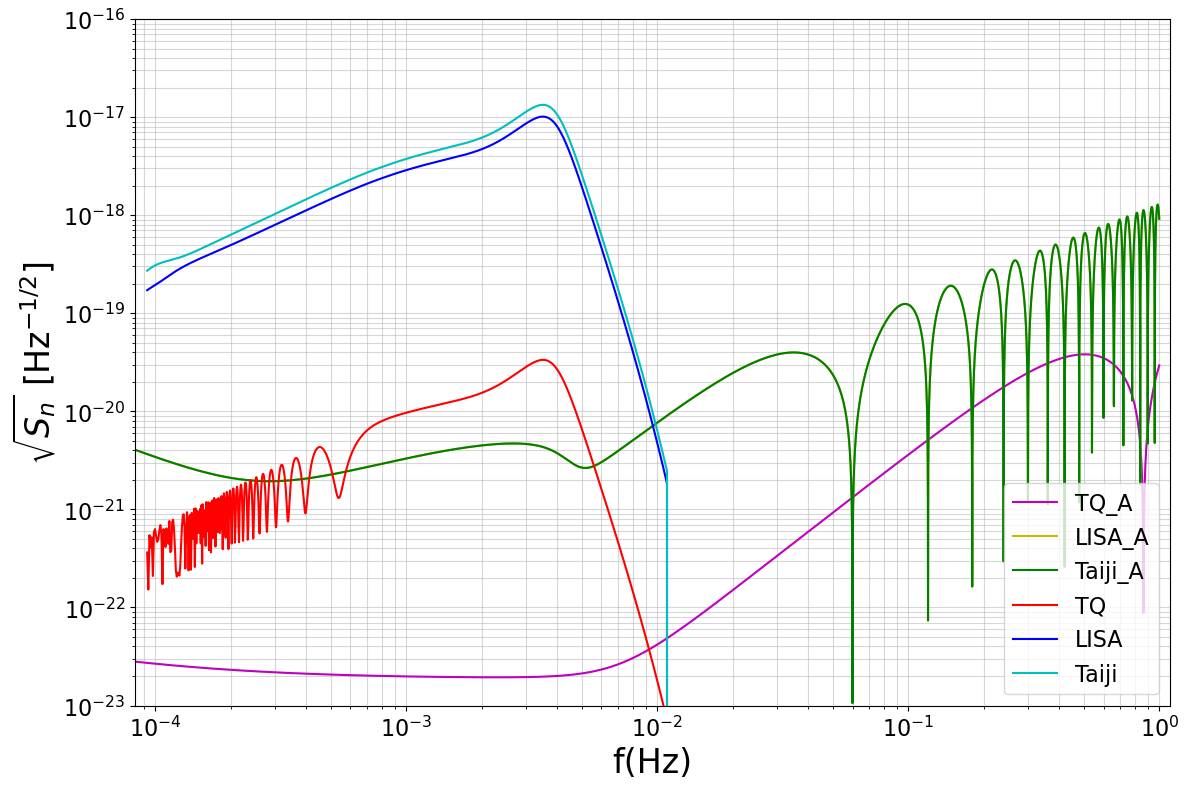

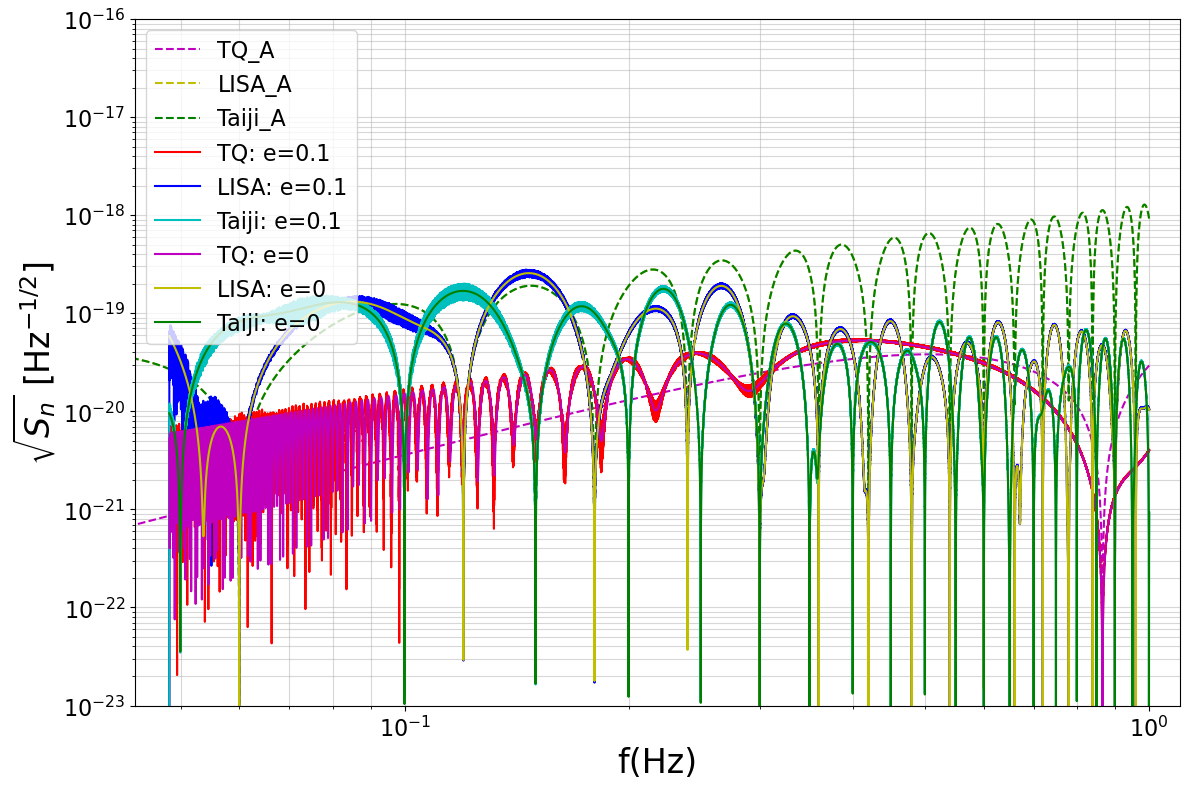

In [4]:
BHBpars = {"mass1": 3.5e6,
           "mass2": 2.1e5,
           'T_obs': MONTH*3,
           "chi1": 0.2,
           "chi2": 0.1,
           "DL": 1e3,
           "psi": 0.2,
           "iota": 0.3,
           "Lambda": 0.4,
           "Beta": 1.2,
           "tc": 0,
           }
ecc_par = {'DL': 100,  # Luminosity distance (Mpc)
           'mass1': 35.6,  # Primary mass (solar mass)
           'mass2': 30.6,  # Secondary mass(solar mass)
           'Lambda': 4.7,  # Longitude
           'Beta': -1.5,  # Latitude
           'phi_c': 0,  # Coalescence phase
           'T_obs': MONTH*3,  # Observation time (s)
           'tc': 0,  # Coalescence time (s)
           'iota': 0.3,  # Inclination angle
           'var_phi': 0,  # Observer phase
           'psi': 0.2,  # Polarization angle
           }  # masses of GW150914
# generate_td_data(GCBpars)
# generate_td_data(EMRIpars, s_type='emri')
# generate_fd_data(BHBpars, show_y_slr=True)
from gwspace.Noise import TianQinNoise, LISANoise, TaijiNoise
tq_noise = TianQinNoise()
lisa_noise = LISANoise()
taiji_noise = TaijiNoise()
freq_ = np.logspace(-5, 0, 10000)
TQ_A, _ = tq_noise.noise_AET(freq_)
LISA_A, _ = lisa_noise.noise_AET(freq_, wd_foreground=90/365.25)
Taiji_A, _ = lisa_noise.noise_AET(freq_, wd_foreground=90/365.25)
BHBwf = waveforms['bhb_PhenomD'](**BHBpars)
delta_f = 1e-6  # 1/BHBwf.T_obs
freq = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)
amp, phase, tf = BHBwf.get_amp_phase(freq)
amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]
h22 = amp*np.exp(1j*phase)*np.exp(2j*np.pi*freq*BHBwf.tc)
SMBBH_A = {}
for d in ['TQ', 'LISA', 'Taiji']:
    det = detectors[d](tf)
    y_slr = trans_y_slr_fd(BHBwf.vec_k, BHBwf.p22, det, freq)[0]
    y_slr = {k: v*h22 for k, v in y_slr.items()}
    SMBBH_A[d], _, _ = get_AET_fd(y_slr, freq, det.L_T)
plt.figure(figsize=(12, 8))
plt.loglog(freq_, np.sqrt(TQ_A), 'm-', label='TQ_A')
plt.loglog(freq_, np.sqrt(LISA_A), 'y-', label='LISA_A')
plt.loglog(freq_, np.sqrt(Taiji_A), 'g-', label='Taiji_A')
plt.loglog(freq, np.abs(SMBBH_A['TQ'])*np.sqrt(freq), 'r-', label='TQ')
plt.loglog(freq, np.abs(SMBBH_A['LISA'])*np.sqrt(freq), 'b-', label='LISA')
plt.loglog(freq, np.abs(SMBBH_A['Taiji'])*np.sqrt(freq), 'c-', label='Taiji')
plt.xlabel('f(Hz)', fontsize=24)
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]', fontsize=24)
plt.tick_params(labelsize=16)
plt.grid(which='both', alpha=0.5)
plt.xlim(0.9*BHBwf.f_min, 1.1)
plt.ylim(1e-23, 1e-16)
plt.legend(fontsize=16)
plt.tight_layout()



BHBwf = waveforms['bhb_PhenomD'](**ecc_par)
delta_f = 1e-5  # 1/BHBwf.T_obs
freq_e0 = np.arange(np.ceil(BHBwf.f_min/delta_f)*delta_f, 1., delta_f)
amp, phase, tf = BHBwf.get_amp_phase(freq_e0)
amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]
h22 = amp*np.exp(1j*phase)*np.exp(2j*np.pi*freq_e0*BHBwf.tc)
ecc_wf = waveforms['bhb_EccFD'](**ecc_par, eccentricity=0.1)
smBBH_A_e0, smBBH_A_e1 = {}, {}
for d in ['TQ', 'LISA', 'Taiji']:
    det = detectors[d](tf)
    y_slr = trans_y_slr_fd(BHBwf.vec_k, BHBwf.p22, det, freq_e0)[0]
    y_slr = {k: v*h22 for k, v in y_slr.items()}
    smBBH_A_e0[d], _, _ = get_AET_fd(y_slr, freq_e0, det.L_T)
    smBBH_A_e1[d], freq_e1 = ecc_wf.fd_tdi_response(det=d, delta_f=delta_f)
plt.figure(figsize=(12, 8))
plt.loglog(freq_, np.sqrt(TQ_A), 'm--', label='TQ_A')
plt.loglog(freq_, np.sqrt(LISA_A), 'y--', label='LISA_A')
plt.loglog(freq_, np.sqrt(Taiji_A), 'g--', label='Taiji_A')
plt.loglog(freq_e1, np.abs(smBBH_A_e1['TQ'])*np.sqrt(freq_e1), 'r-', label='TQ: e=0.1')
plt.loglog(freq_e1, np.abs(smBBH_A_e1['LISA'])*np.sqrt(freq_e1), 'b-', label='LISA: e=0.1')
plt.loglog(freq_e1, np.abs(smBBH_A_e1['Taiji'])*np.sqrt(freq_e1), 'c-', label='Taiji: e=0.1')
plt.loglog(freq_e0, np.abs(smBBH_A_e0['TQ'])*np.sqrt(freq_e0), 'm-', label='TQ: e=0')
plt.loglog(freq_e0, np.abs(smBBH_A_e0['LISA'])*np.sqrt(freq_e0), 'y-', label='LISA: e=0')
plt.loglog(freq_e0, np.abs(smBBH_A_e0['Taiji'])*np.sqrt(freq_e0), 'g-', label='Taiji: e=0')
plt.xlabel('f(Hz)', fontsize=24)
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]', fontsize=24)
plt.tick_params(labelsize=16)
plt.grid(which='both', alpha=0.5)
plt.xlim(0.9*BHBwf.f_min, 1.1)
plt.ylim(1e-23, 1e-16)
plt.legend(fontsize=16)
plt.tight_layout()